## Tutorial II: Optimization in **pytorch** and NN introduction

<p>
Bern Winter School on Machine Learning, 2024<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [1]:
# time to teach without exercises 50mins

## 1. Load necessary libraries

In [2]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time



## 2. Linear fit

Here we will solve optimization problem to perform linear regression. First we will generate training set of 80 data points and test set of 20, laying on a line with a random offset $$y = a_0 x + b_0 + \delta,$$ where $\delta$ is a random variable sampled from a uniform distribution with standard deviation equal to $s_0$.
<!-- o.f.: 46, 48, 87, 99 | val better than train: 47, 56, 86. -->

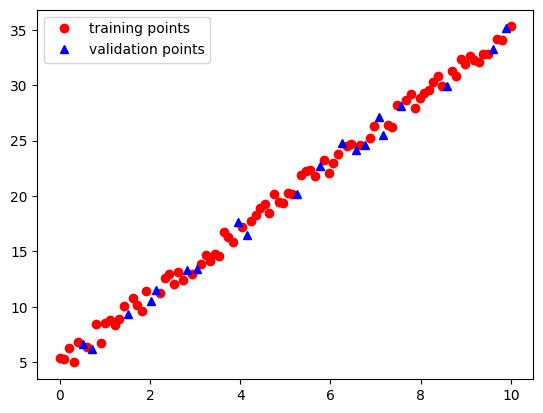

In [3]:
a0 = 3  # 3
b0 = 5  # 5
s0 = 1  # 1

n_all = 100

np.random.seed(99)

# all samples
x_all = np.linspace(0, 10, n_all)  # 100 points
d_all = np.random.uniform(-s0, s0, size=n_all)
y_all = np.asarray([a0*x + b0 + d for x, d in zip(x_all, d_all)])

# randomize order and get 80% for training
idx = np.random.permutation(n_all)
n_train = n_all * 80 // 100

idx_train = idx[0:n_train]
idx_val = idx[n_train:]

x_train, y_train = x_all[idx_train], y_all[idx_train]

x_val, y_val = x_all[idx_val], y_all[idx_val]

plt.plot(x_train, y_train, "or", x_val, y_val, "b^")
plt.legend(('training points', 'validation points'),  loc='upper left');

We will then define loss function as the mean of squared residuals (distance from line along $y$) for the points.

We will use [stochactic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent): on each iteration use only a fraction (`batch_size`) of all training set. In many cases training set is huge and cannot be fed on each iteration in principle. Also it can sometimes help the optimizer to properly explore the manifold.

In [4]:
class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.a = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.a * x + self.b


def loss_f(true_y, y_predicted):
    return F.mse_loss(y_predicted, true_y)

In [5]:
# Define the model
model = Linear()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Define the number of epochs and batch size
epochs = 400 # epoch = one iteration of the entire training dataset (so in our example 1 epoch = 8 iteration of batch)
batch_size = 10


x_train = torch.tensor(x_train)  # watch out for d-type issues with torch.tensors
y_train = torch.tensor(y_train)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)



# Training loop
train_loss_history = []
val_loss_history = []
for epoch in range(epochs):
    model.train()  # as opposed to model.eval()
    batch_losses = []
    permutation = torch.randperm(x_train.size()[0])


    for i in range(0, x_train.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]

        # Forward pass
        outputs = model(batch_x)

        # Compute the loss
        loss = loss_f(batch_y, outputs)
        batch_losses.append(loss.item())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    average_training_loss = np.mean(batch_losses)
    train_loss_history.append(average_training_loss)

    # Validation step (optional, for monitoring performance)
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = loss_f(y_val, val_outputs)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss.item()}")



Epoch 1/400, Validation Loss: 80.56227076143323
Epoch 2/400, Validation Loss: 12.859853515226897
Epoch 3/400, Validation Loss: 6.339516046574174
Epoch 4/400, Validation Loss: 5.710270549908131
Epoch 5/400, Validation Loss: 5.605497729384848
Epoch 6/400, Validation Loss: 5.513764580386011
Epoch 7/400, Validation Loss: 5.4303323249378534
Epoch 8/400, Validation Loss: 5.339049611969389
Epoch 9/400, Validation Loss: 5.251847675714477
Epoch 10/400, Validation Loss: 5.1710998595882
Epoch 11/400, Validation Loss: 5.086956209301307
Epoch 12/400, Validation Loss: 5.002530543562665
Epoch 13/400, Validation Loss: 4.922297373263678
Epoch 14/400, Validation Loss: 4.843662979025849
Epoch 15/400, Validation Loss: 4.7708924000412205
Epoch 16/400, Validation Loss: 4.690490244444142
Epoch 17/400, Validation Loss: 4.614271264108092
Epoch 18/400, Validation Loss: 4.540075495440388
Epoch 19/400, Validation Loss: 4.470503820141959
Epoch 20/400, Validation Loss: 4.401476492397842
Epoch 21/400, Validation Los

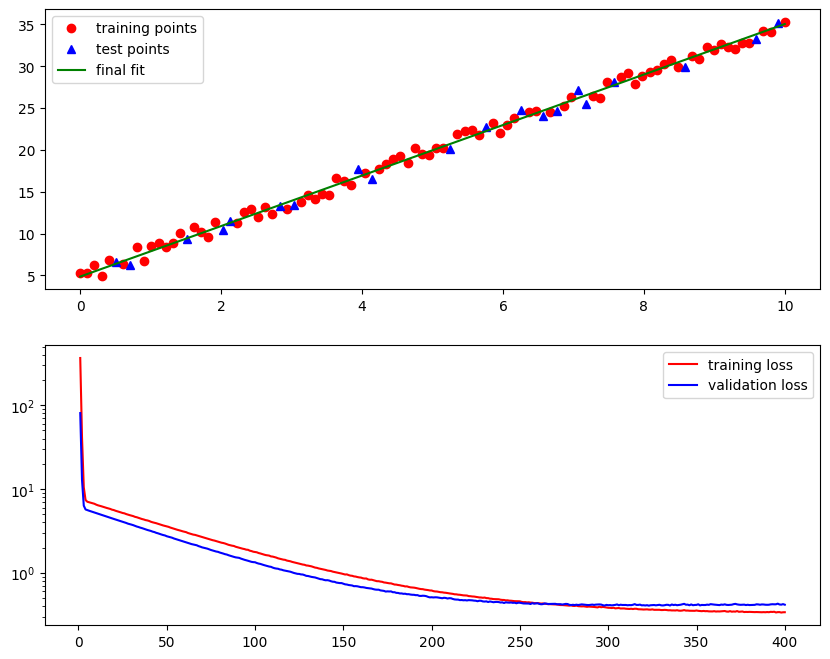

In [6]:
a_val, b_val = model.a.item(), model.b.item()

# Generate predictions for plotting
end_fit_x = [x_all[0], x_all[-1]]
end_fit_y = [a_val * x + b_val for x in end_fit_x]
true_fn_y = [a0 * x + b0 for x in end_fit_x]  # Assuming a0 and b0 are known true values

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plotting data points and model predictions
axs[0].plot(x_train, y_train, 'ro', x_val, y_val, 'b^', end_fit_x, end_fit_y, 'g')
axs[0].legend(('training points', 'test points', 'final fit'), loc='upper left')

# Assuming training and validation loss history are stored in lists: train_loss_history and val_loss_history
epochs = range(1, len(train_loss_history) + 1)

# Plotting loss history
axs[1].semilogy(epochs, train_loss_history, 'r')
axs[1].semilogy(epochs, val_loss_history, 'b')
axs[1].legend(('training loss', 'validation loss'), loc='upper right')

plt.show()

## 3. Exercise 1

Play with the true function parameters ```a0, b0, s0``` and the ``batch_size`` value, check how it affects the convergence.

1. How change of `s0` affects convergance?
2. When one should stop training to prevent overfitting?

Epoch 3200/3200, Validation Loss: 0.4212517528725478


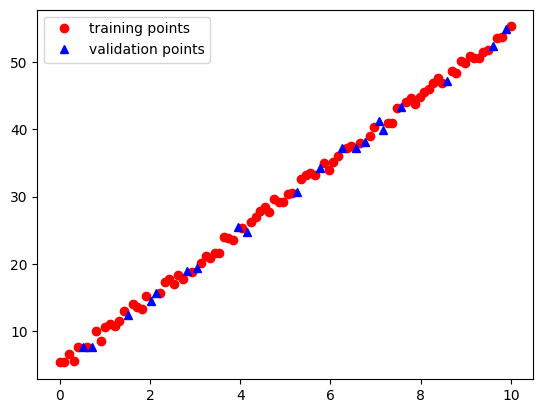

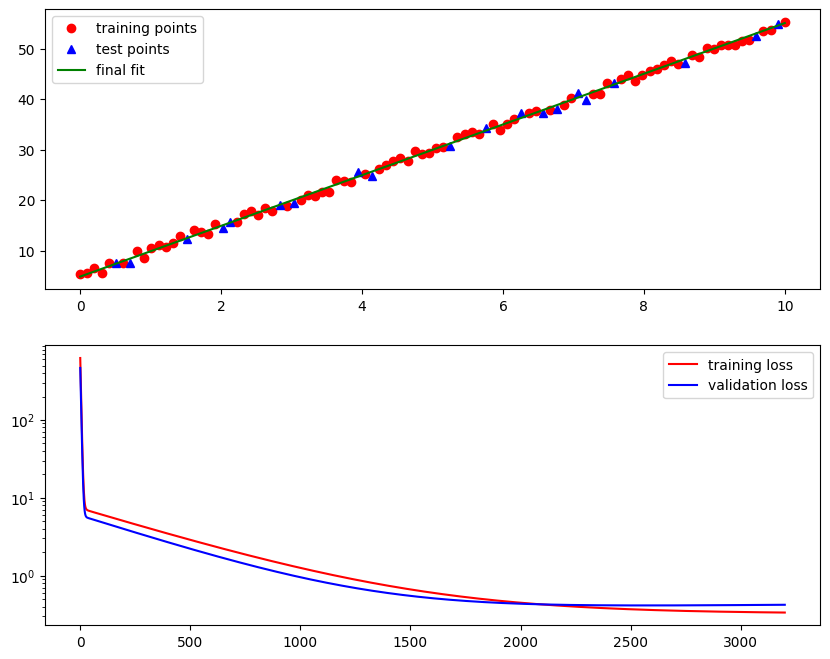

Execution time: 3.317826271057129 seconds


In [7]:
# get the start time
st = time.time()

a0 = 5  # 3
b0 = 5  # 5
s0 = 1  # 1

n_all = 100

np.random.seed(99)

# all samples
x_all = np.linspace(0, 10, n_all)  # 100 points
d_all = np.random.uniform(-s0, s0, size=n_all)
y_all = np.asarray([a0*x + b0 + d for x, d in zip(x_all, d_all)])

# randomize order and get 80% for training
idx = np.random.permutation(n_all)
n_train = n_all * 80 // 100

idx_train = idx[0:n_train]
idx_val = idx[n_train:]

x_train, y_train = x_all[idx_train], y_all[idx_train]

x_val, y_val = x_all[idx_val], y_all[idx_val]

plt.plot(x_train, y_train, "or", x_val, y_val, "b^")
plt.legend(('training points', 'validation points'),  loc='upper left');

class Linear(nn.Module):
    def __init__(self):
        super(Linear, self).__init__()
        self.a = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.a * x + self.b


def loss_f(true_y, y_predicted):
    return F.mse_loss(y_predicted, true_y)


# Define the model
model = Linear()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002)

# Define the number of epochs and batch size
epochs = 400*8 # epoch = one iteration of the entire training dataset (so in our example 1 epoch = 8 iteration of batch)
batch_size = 80


x_train = torch.tensor(x_train)  # watch out for d-type issues with torch.tensors
y_train = torch.tensor(y_train)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)



# Training loop
train_loss_history = []
val_loss_history = []
for epoch in range(epochs):
    model.train()  # as opposed to model.eval()
    batch_losses = []
    permutation = torch.randperm(x_train.size()[0])


    for i in range(0, x_train.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]

        # Forward pass
        outputs = model(batch_x)

        # Compute the loss
        loss = loss_f(batch_y, outputs)
        batch_losses.append(loss.item())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    average_training_loss = np.mean(batch_losses)
    train_loss_history.append(average_training_loss)

    # Validation step (optional, for monitoring performance)
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = loss_f(y_val, val_outputs)
        val_loss_history.append(val_loss)
        #print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss.item()}")

a_val, b_val = model.a.item(), model.b.item()
print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss.item()}")
# Generate predictions for plotting
end_fit_x = [x_all[0], x_all[-1]]
end_fit_y = [a_val * x + b_val for x in end_fit_x]
true_fn_y = [a0 * x + b0 for x in end_fit_x]  # Assuming a0 and b0 are known true values

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plotting data points and model predictions
axs[0].plot(x_train, y_train, 'ro', x_val, y_val, 'b^', end_fit_x, end_fit_y, 'g')
axs[0].legend(('training points', 'test points', 'final fit'), loc='upper left')

# Assuming training and validation loss history are stored in lists: train_loss_history and val_loss_history
epochs = range(1, len(train_loss_history) + 1)

# Plotting loss history
axs[1].semilogy(epochs, train_loss_history, 'r')
axs[1].semilogy(epochs, val_loss_history, 'b')
axs[1].legend(('training loss', 'validation loss'), loc='upper right')

plt.show()

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

*A smaller batch size increase time. A small batch size allows to avoid local minimum.*

*In real life application, try to avoid batch size bigger than 10% of the train dataset.*

*If we increase the epoch number by a factor similar to the one used for the batch_size, we get the same number of iterations and at the end we have more or less the same value for the loss function.*

*To see if we overfit or not, we need to try to see if we reach a minimum with the validation loss. If the validation loss start to increase, the model is beginning to overfit.*

## 4. Training loop

The training as we just saw is done iteratively, by adjusting the model parameters.

We perform optimization several times for all traininng dataset. Going through all this dataset is refered to as 'epoch'.

When we do training its usually done in two loops. In outer loop we iterate over all epochs. For each epoch we usually split the dataset into small chuncks, batches, and optimization it performed for all of those.

It is important that data doesn't go to the training pipeline in same order. So the overall scheme looks like this (pseudocode):


```
x,y = get_training_data()
for epoch in range(number_epochs):
   x_shfl,y_shfl = shuffle(x,y)
   
   for mb_idx in range(number_minibatches_in_batch):
       x_mb,y_mb = get_minibatch(x_shfl,y_shfl, mb_idx)
       
       optimize_on(data=x_mb, labels=y_mb)
```

## 5. Bulding blocks of a neural network

Neural network consists of layers of neurons. Each neuron perfroms 2 operations.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/Perceptron.png" alt="drawing" width="30%"/>

Each neuron performs 2 operations.

1. Calculate the linear transformation of the input vector $\mathbf{x}_i$:
$$z_i = \mathbf{w} \cdot \mathbf{x}_i + b = \sum_j {w_j x_{ij}} + b$$ where $\mathbf{w}$ is a weight vector and $b$ - a bias, and $j$ traverses each dimension of the input vector
2. Perform the nonlinear transformation of the result using the activation function $f$ $$y_i = f(z_i)$$

In a fully connected neural network, each layer is a set of N neurons, performing different transformations of the input $\mathbf{x}_i$ of the same layer, now producing an output **vector** $ \mathbf{y} _i = f(\mathbf{z}_i) = f(W\mathbf{x}_i + \mathbf{b})$ now with a bias vector $\mathbf{b}$ and a * *matrix** of weights $W$.

Since the output of each layer constitutes the input to the next layer, we can write for layer $l$: $$\mathbf{x}^l_i = f^{l-1}(\mathbf{W}^{ l-1} \mathbf{x}^{ l-1}_i + \mathbf{b}^{l-1})$$ where $\mathbf{x}_i^{l=0}$ is the vector d 'network input for data point $i$.

<img src="https://github.com/neworldemancer/BMLWS/raw/main/figures/MLP.png" alt="drawing" width="50%"/>

To simplify building the network, we'll define a helper function, creating neuron layer with given number of outputs:

In [ ]:
class Dense(nn.Module):
    def __init__(self, input_units, output_units, activation=None):
        """
        Fully connected layer implemented with explicit matrix multiplication.

        Parameters
        ----------
        input_units : int
            Number of input neurons
        output_units : int
            Number of output neurons
        activation : callable or None, optional
            Non-linear activation function (e.g., F.relu)
        """
        super(Dense, self).__init__()
        self.input_units = int(input_units)
        self.output_units = int(output_units)
        self.activation = activation

        # Initialize weights and biases
        self.weights = nn.Parameter(torch.randn(input_units, output_units))
        self.bias = nn.Parameter(torch.randn(output_units))

    def forward(self, x):
        """
        Forward pass through the layer.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        torch.Tensor
            Output of the layer
        """

        outputs = torch.matmul(x, self.weights) + self.bias

        # Apply activation function if provided
        if self.activation is not None:
            # Check if the activation function is softmax
            if self.activation == F.softmax:
                # Apply softmax with specified dimension
                outputs = self.activation(outputs, dim=1)
            else:
                # apply other activation functions normally
                outputs = self.activation(outputs)

        return outputs


In the case of multi-class classification, in the last layer, we can use the *softmax* transformation as a non-linear transformation. The softmax for the $j$th element of $\mathbf{z}_i$ is $$y_{ij} = \frac{e^{z_{ij}}}{\sum_{k=1}^{K} e^{z_{ik}}}$$ where $K$ is the total number of classes.


For example. before softmax $$[1.0, 2.0, 3.0, \mathbf{4.0} ]$$ and after: $$[0.0321, 0.0871, 0.2369, \mathbf{0.6439}]$$ (now the sum is equal to one)

We can also now compare the fundamental truth which could be $$[0,0,0,\mathbf{1}]$$ That is to say that class 4 is the good class and that the network predicted correctly.
## 6. Bulding a neural network

https://medium.com/geekculture/how-visualizations-help-make-sense-of-deep-learning-a408ab00688f

In [ ]:
n_input = 10
n_output = 2
num_datapoints = 1
input_tensor = torch.randn(num_datapoints, n_input)
dense = Dense(input_units=n_input , output_units=n_output, activation=torch.sigmoid)


# remember to matrix multiply A and B we need the shapes (a1 x a2) (b1 x b2) to be such that a2=b1
# the result will be (a1 x b2)

print(dense.weights.shape)
print(input_tensor.shape)
print(torch.matmul(input_tensor, dense.weights).shape) # this is XW  e.g. (1, 10)x(10, 2) = (1 x 2)

# notice that increasing the number of data points does not change the shape of W!
# This is important - the parameter shape should not change according to the number of datapoints, only their dimenaionality

torch.Size([10, 2])
torch.Size([1, 10])
torch.Size([1, 2])


In [ ]:
# if we want to stack multiple dense operations together
hidden_dim = 10
dense1 =  Dense(input_units=n_input , output_units=hidden_dim, activation=torch.sigmoid)
dense2 =  Dense(input_units=hidden_dim , output_units=n_output, activation=F.softmax)
output = dense2(dense1(input_tensor))

In [ ]:
# integrate everything into an overall model

class MyModel(nn.Module):
    def __init__(self, input_units, hidden_units, output_units):
        super(MyModel, self).__init__()
        # Define a Dense layer
        self.dense1 = Dense(input_units, hidden_units, activation=F.relu)
        # Define another Dense layer
        self.dense2 = Dense(hidden_units, output_units, activation=F.softmax)

    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

    def predict(self, x):
        # Forward pass and get predictions
        preds = self.dense2(self.dense1(x))
        print(preds)  # to check values before argmax
        return torch.argmax(preds, dim=1)

# Example usage
input_units = 10
hidden_units = 5
output_units = 2
model = MyModel(input_units, hidden_units, output_units)

# Create a sample input tensor
input_tensor = torch.randn(5, input_units)

# Get predictions
predictions = model.predict(input_tensor)
print(predictions)

tensor([[0.3706, 0.6294],
        [0.0025, 0.9975],
        [0.1835, 0.8165],
        [0.7004, 0.2996],
        [0.7276, 0.2724]], grad_fn=<SoftmaxBackward0>)
tensor([1, 1, 1, 0, 0])
